In [1]:
from IPython.display import HTML

HTML("""
<style>
/* JupyterLab: center notebook and leave margins */
.jp-NotebookPanel-notebook {
  width: 85% !important;              
  margin-left: auto !important;
  margin-right: auto !important;
  max-width: 1100px !important;       /* optional cap */
}

/* Make output area match nicely */
.jp-OutputArea {
  max-width: 100% !important;
}
</style>
""")

In [2]:
import torch

def detect_torch_device(verbose: bool = True) -> str:
    """
    Returns one of: 'cuda', 'mps', 'cpu'
    Priority: CUDA GPU > Apple MPS > CPU
    """
    has_cuda = torch.cuda.is_available()
    has_mps = getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available()

    if has_cuda:
        device = "cuda"
    elif has_mps:
        device = "mps"
    else:
        device = "cpu"

    if verbose:
        print(f"torch: {torch.__version__}")
        print(f"device: {device}")

        if has_cuda:
            print(f"cuda devices: {torch.cuda.device_count()}")
            for i in range(torch.cuda.device_count()):
                print(f"  [{i}] {torch.cuda.get_device_name(i)}")
        elif has_mps:
            print("mps available: True (Apple Metal)")
        else:
            print("cpu only")

    return device

device = detect_torch_device()

torch: 2.9.1
device: mps
mps available: True (Apple Metal)


In [3]:
import torch
print("torch:", torch.__version__)
print("mps built:", torch.backends.mps.is_built())
print("mps available:", torch.backends.mps.is_available())

x = torch.rand(2, 3)
print(x)

if torch.backends.mps.is_available():
    x = x.to("mps")
    print("device:", x.device)

torch: 2.9.1
mps built: True
mps available: True
tensor([[0.0378, 0.3469, 0.2361],
        [0.3716, 0.4962, 0.1871]])
device: mps:0


## 1. Explore LLMs via ollama

### 1.1  Install ollama and download Qwen3:0.6b and Qwen3:1.7b

We can download some popular LLMs such as Qwen series.

- Download ollama to your laptop from [https://ollama.com/download](https://ollama.com/download)
- Run ```shell ollama run qwen3:0.6b ```, it will automatically download the model into your local disk. It takes about 498MB disk space.
- Similarly, you can run, ```shell ollama run qwen3:1.7b ```. It takes about 1.3GB disk space.

You can install the python api of ollama via the following commands.

In [ ]:
!conda install conda-forge::ollama -y

In [ ]:
!conda install -c conda-forge ollama-python -y

### 1.2 Get response for a given prompt

In [29]:
import os
import time
import math
import ollama

# If you have proxy, make sure bypass proxies for local services (e.g., Ollama on localhost:11434)
# You can check whether Ollama is running or not by tpying: http://127.0.0.1:11434/ in your Chrome.
os.environ["NO_PROXY"] = "localhost,127.0.0.1"
os.environ["no_proxy"] = "localhost,127.0.0.1"

models = ["qwen3:0.6b", "qwen3:1.7b"]
prompt = "Fudan University is located in which city? Answer with one word."

for model in models:
    print('-' * 50)
    start_time = time.time()
    for _ in range(10):
        resp = ollama.generate(
            model = model,
            prompt = prompt
        )
        print(f"{model} with resp {_ + 1}: {resp["response"]}")
    print(f'total runtime of 10 responses of {model} is: {time.time() - start_time:.1f} seconds')

--------------------------------------------------
qwen3:0.6b with resp 1: Hangzhou
qwen3:0.6b with resp 2: Shanghai
qwen3:0.6b with resp 3: Beijing
qwen3:0.6b with resp 4: Shanghai
qwen3:0.6b with resp 5: Beijing
qwen3:0.6b with resp 6: Hangzhou
qwen3:0.6b with resp 7: Hangzhou
qwen3:0.6b with resp 8: Hangzhou
qwen3:0.6b with resp 9: Hangzhou
qwen3:0.6b with resp 10: Shanghai
total runtime of 10 responses of qwen3:0.6b is: 9.5 seconds
--------------------------------------------------
qwen3:1.7b with resp 1: Shanghai
qwen3:1.7b with resp 2: Shanghai
qwen3:1.7b with resp 3: Shanghai
qwen3:1.7b with resp 4: Shanghai
qwen3:1.7b with resp 5: Shanghai
qwen3:1.7b with resp 6: Shanghai
qwen3:1.7b with resp 7: Shanghai
qwen3:1.7b with resp 8: Shanghai
qwen3:1.7b with resp 9: Shanghai
qwen3:1.7b with resp 10: Shanghai
total runtime of 10 responses of qwen3:1.7b is: 23.5 seconds


**Some key observations:**

- The smaller model Qwen3:0.6b produces lower quality answers while the relative bigger model Qwen3:1.7b produces high quality answers.
- The response is a kind of random as each time the response may not be the same.

Certainly, there are ways to make sure the above to generate a fixed answer. For example, you can use the following code where each time it always produce the maximal probability as the answer:

```python
resp = ollama.generate(
    model=model,
    prompt=prompt,
    options={
        "temperature": 0.0,
        "top_p": 1.0,
        "top_k": 0,
        # optional:
        "num_predict": 32,
    },
)
print(resp["response"])
```

Let us generate some response that are not one word but a sequence of words.

In [28]:
model = "qwen3:1.7b"
prompt = "I am an undergraduate student, please explain LLMs in three sentences."
resp = ollama.generate(
            model=model,
            prompt=prompt
        )
print(f"Prompt: {prompt} \nResp: {resp["response"]}")

Prompt: I am an undergraduate student, please explain LLMs in three sentences. 
Resp: Large Language Models (LLMs) are AI systems trained on massive text datasets to understand and generate human-like text. They excel at tasks like writing essays, coding, and translating languages by learning patterns and context from vast amounts of data. LLMs rely on deep learning techniques, such as transformer architectures, to predict subsequent words or phrases, enabling them to perform complex tasks with remarkable accuracy.


### 1.3 Get response probability from LLMs

From above outputs, you see that each time, the response of these LLMs could be different. Actually, all LLMs are probabilitic model where each time, they response (i.e., answers) prompts (i.e., questions) differently. We can use math language to describe this inference process.

Let $p_\theta(\cdot)$ be the trained probability model. Here, you can think $p_\theta(\cdot)$ as Qwen3:0.6b, Qwen3:1.7b or any other models. Given the prompt *Fudan University is located in which city? Answer with one word.* (a sequence of tokens), the above response will give you an answer, which is also a sequence of tokens. So, the model will use an algorithm to predict the response given the prompt. Use the math language, we can think it tries to calculate the following probability:

$$
p_\theta \left(w_{n+1}|w_1,w_2,\ldots, w_{n}\right),
$$
where
- Prompt=[*Fudan University is located in which city? Answer with one word.]* $=[w_1,w_2,\ldots, w_{n}]$,
- Response=[$w_{n+1}$].

The model will try to output the most likeliy word $w_{n+1}$ using its own *inference algorithm*. We will detail this part in later lectures. By the definition of conditional probability, we may calculate it as

$$
p_\theta \left(w_{n+1}|w_1,w_2,\ldots, w_{n}\right) = \frac{ p_\theta \left(w_1,w_2,\ldots, w_{n}, w_{n+1}\right)}{p_\theta \left(w_1,w_2,\ldots, w_{n}\right)}.
$$

The above is essential to say that, if we can learn a model that can represent any length sequence of distribution $p_\theta \left(w_1,w_2,\ldots, w_{k}\right)$, where $k$ could be any positive integer, then we can compute the conditional distribution easily.

In [48]:
model = "qwen3:0.6b" # "qwen3:1.7b"
prompt = "Fudan University is located in which city? Answer with one word."
num_top_tokens = 20 # number of top alternatives per generated token
resp = ollama.generate(
    model = model,
    prompt = prompt,
    stream = False,
    logprobs = True,
    think = False,
    top_logprobs = num_top_tokens
)
print("response:", repr(resp["response"]))

# Each element usually corresponds to one generated token
for i, lp in enumerate(resp.get("logprobs", [])):
    tok = lp.get("token")
    logp = lp.get("logprob")
    p = math.exp(logp) if logp is not None else None
    print(f"{i:02d} token={tok!r:>16} logp={logp: .4f} p={p:.4f}")

response: 'Beijing'
00 token=            'Be' logp=-0.7104 p=0.4914
01 token=         'ijing' logp=-0.2248 p=0.7987


In [94]:
import os, math, ollama

model = "qwen3:0.6b"
prompt = "Fudan University is located in which city? Answer with one word."

res = ollama.generate(
    model=model,
    prompt=prompt,
    logprobs=True,
    think = False,
    top_logprobs=10,
    options={"temperature": 0.0, # greedy decoding, it pick the maximal token
             "num_predict": 20,
            "think": False # do not use thinking model.
            },
)

answer = ''
lp = res["logprobs"]
tokens = [d.get("token", "") for d in lp]
print(f'We use model: {model}')
for i in range(len(lp)):
    tok = lp[i].get("token", "")
    logp = lp[i].get("logprob", None)
    alts = lp[i].get("top_logprobs", [])
    p = math.exp(logp) if logp is not None else float("nan")
    if tok == "\n" or tok == "\n\n": # stop when answer ends (often newline).
        break
    answer += tok
    print(f"--- top probabilities of token-{i:02d} ---")
    for a in alts[:20]:
        prob_a = math.exp(a['logprob'])
        print(f"{a['token']!r:>12}:{prob_a:.5f}")
    print(f"Partial Response: {answer}\n")
print(f"Final Response: {answer}")

We use model: qwen3:0.6b
--- top probabilities of token-00 ---
        'Be':0.49277
        'Sh':0.19577
         'F':0.15628
        'Ch':0.05104
        'Gu':0.02999
         'H':0.01773
         'S':0.00861
         'J':0.00580
         'Y':0.00487
         'B':0.00325
Partial Response: Be

--- top probabilities of token-01 ---
     'ijing':0.79945
        'ij':0.04640
        'ih':0.03969
     'iping':0.02474
        'iz':0.01514
        'id':0.01411
        'il':0.01020
        'iy':0.00864
      'jing':0.00839
        'ib':0.00624
Partial Response: Beijing

Final Response: Beijing


In [93]:
model = "qwen3:1.7b"
prompt = "Fudan University is located in which city? Answer with one word."

res = ollama.generate(
    model=model,
    prompt=prompt,
    logprobs=True,
    think = False,
    top_logprobs=10,
    options={"temperature": 0.0, # greedy decoding, it pick the maximal token
             "num_predict": 20,
            "think": False # do not use thinking model.
            },
)
print(res["response"])

Fudan University is located in **Shanghai**.


If we do not use thinking mode, it will gives the above response. However, we can still see how Shanghai is chosen during the inference stage.

In [92]:
import os, math, ollama

model = "qwen3:1.7b"
prompt = "Fudan University is located in which city? Answer with one word."

res = ollama.generate(
    model=model,
    prompt=prompt,
    logprobs=True,
    think = False, # Do not use the thinking model.
    top_logprobs=10,
    options={"temperature": 0.0, # greedy decoding, it pick the maximal token
             "num_predict": 20,
            "think": False # do not use thinking model.
            },
)

answer = ''
lp = res["logprobs"]
tokens = [d.get("token", "") for d in lp]
print(f'We use model: {model}')
for i in range(len(lp)):
    tok = lp[i].get("token", "")
    logp = lp[i].get("logprob", None)
    alts = lp[i].get("top_logprobs", [])
    p = math.exp(logp) if logp is not None else float("nan")
    if tok == "\n" or tok == "\n\n": # stop when answer ends (often newline).
        break
    answer += tok
    print(f"--- top probabilities of token-{i:02d} ---")
    for a in alts[:20]:
        prob_a = math.exp(a['logprob'])
        print(f"{a['token']!r:>12}:{prob_a:.5f}")
    print(f"Partial Response: {answer}\n")
print(f"Final Response: {answer}")

We use model: qwen3:1.7b
--- top probabilities of token-00 ---
         'F':0.99949
        'An':0.00017
        'Sh':0.00016
        'Fu':0.00014
         'W':0.00001
         'Z':0.00001
         'P':0.00000
      'Hang':0.00000
         'J':0.00000
        'Be':0.00000
Partial Response: F

--- top probabilities of token-01 ---
        'ud':0.99999
        'uj':0.00001
        'uz':0.00000
     'uding':0.00000
        'uy':0.00000
       'udu':0.00000
        'UD':0.00000
       'uda':0.00000
       'udd':0.00000
      'udge':0.00000
Partial Response: Fud

--- top probabilities of token-02 ---
        'an':1.00000
       'ans':0.00000
        'am':0.00000
        'ан':0.00000
     'anian':0.00000
       'anh':0.00000
        'un':0.00000
        'AN':0.00000
        'on':0.00000
       'ian':0.00000
Partial Response: Fudan

--- top probabilities of token-03 ---
' University':1.00000
'University':0.00000
  ' Univers':0.00000
     ' Univ':0.00000
 ' Universe':0.00000
' Universities':0.

## 2. Histroy of NLP and LLMs

Please check this part in our slides.

### 2.1 Download datasets

Please note that huggingface cannot be directly used in China. An alternative way is to use [https://hf-mirror.com/](https://hf-mirror.com/).

In [1]:
import os
# If this does not work, please add export HF_ENDPOINT=https://hf-mirror.com in your env.
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_ETAG_TIMEOUT"] = "60"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "60"

from datasets import load_dataset

# loads train/validation/test
ds = load_dataset("wikitext", "wikitext-2-raw-v1")

/opt/anaconda3/envs/llm-26/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(ds)
train = ds["train"]
for i in range(5):
    print(train[i])

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
{'text': ''}
{'text': ' = Valkyria Chronicles III = \n'}
{'text': ''}
{'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted aga

Fitted Heaps' law: |V| ≈ 15.76 * N^0.578


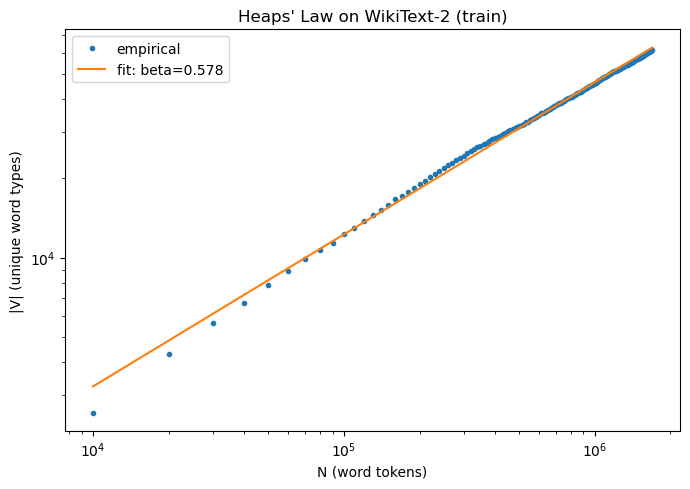

In [5]:
import re
import numpy as np
import matplotlib.pyplot as plt

train = ds["train"]

# simple word tokenizer (lowercased)
word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def heaps_curve(dataset, step=10_000):
    V = set()
    N = 0
    Ns, Vs = [], []

    for ex in dataset:
        text = ex["text"]
        if not text or text.strip() == "": # empty word -> continue
            continue
        # make all words to low cases
        words = word_re.findall(text.lower()) 
        for w in words:
            N += 1
            V.add(w)

            if N % step == 0:
                Ns.append(N)
                Vs.append(len(V))
    return np.array(Ns), np.array(Vs)

Ns, Vs = heaps_curve(train, step=10_000)

# Fit log |V| = log k + beta log N  -> linear regression on logs
logN = np.log(Ns)
logV = np.log(Vs)
beta, logk = np.polyfit(logN, logV, 1)
k = np.exp(logk)

print(f"Fitted Heaps' law: |V| ≈ {k:.2f} * N^{beta:.3f}")

# Plot (log-log)
plt.figure(figsize=(7, 5))
plt.loglog(Ns, Vs, marker='o', linestyle='none', markersize=3, label="empirical")

# fitted line
Ns_line = np.linspace(Ns[0], Ns[-1], 200)
Vs_line = k * (Ns_line ** beta)
plt.loglog(Ns_line, Vs_line, label=f"fit: beta={beta:.3f}")

plt.xlabel("N (word tokens)")
plt.ylabel("|V| (unique word types)")
plt.title("Heaps' Law on WikiText-2 (train)")
plt.legend()
plt.tight_layout()
plt.show()

Fitted Heaps' law (spaCy): |V| ≈ 15.11 * N^0.582


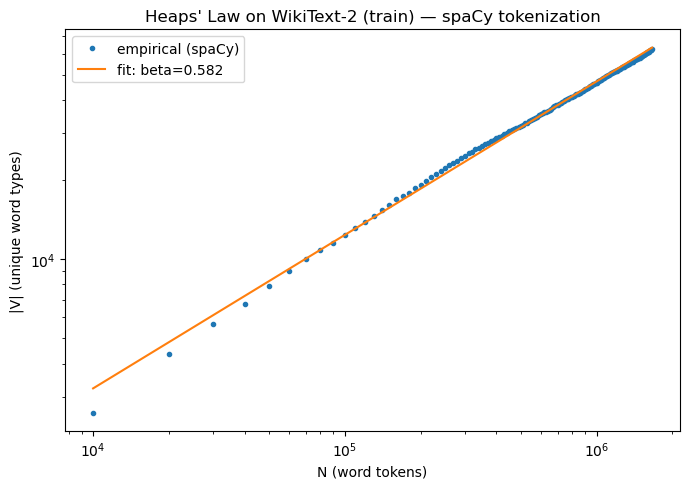

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import spacy

nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","ner","lemmatizer"])
# tokenizer still works even with pipeline disabled

train = ds["train"]

def heaps_curve_spacy(dataset, step=10_000, batch_size=256):
    V = set()
    N = 0
    Ns, Vs = [], []

    texts = (ex["text"] for ex in dataset if ex["text"] and ex["text"].strip())
    for doc in nlp.pipe(texts, batch_size=batch_size):
        for tok in doc:
            # choose your definition of "word"
            if tok.is_alpha:
                w = tok.text.lower()
                N += 1
                V.add(w)
                if N % step == 0:
                    Ns.append(N)
                    Vs.append(len(V))
    return np.array(Ns), np.array(Vs)

Ns, Vs = heaps_curve_spacy(train, step=10_000)

# Fit log |V| = log k + beta log N
logN = np.log(Ns)
logV = np.log(Vs)
beta, logk = np.polyfit(logN, logV, 1)
k = np.exp(logk)

print(f"Fitted Heaps' law (spaCy): |V| ≈ {k:.2f} * N^{beta:.3f}")

plt.figure(figsize=(7, 5))
plt.loglog(Ns, Vs, marker='o', linestyle='none', markersize=3, label="empirical (spaCy)")

Ns_line = np.linspace(Ns[0], Ns[-1], 200)
plt.loglog(Ns_line, k * (Ns_line ** beta), label=f"fit: beta={beta:.3f}")

plt.xlabel("N (word tokens)")
plt.ylabel("|V| (unique word types)")
plt.title("Heaps' Law on WikiText-2 (train) — spaCy tokenization")
plt.legend()
plt.tight_layout()
plt.show()

We can download a larger dataset from the following:

```shell
export HF_HOME=$HOME/.cache/huggingface

huggingface-cli download Salesforce/wikitext --repo-type dataset --resume-download --include "wikitext-103-raw-v1/*.parquet"
```

In [7]:
from datasets import load_dataset
ds = load_dataset("wikitext", "wikitext-103-raw-v1")  # will hit cache if present

Generating validation split: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3760/3760 [00:00<00:00, 1236811.47 examples/s]


In [8]:
print(ds)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 1801350
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


Fitted Heaps' law: |V| ≈ 31.62 * N^0.527


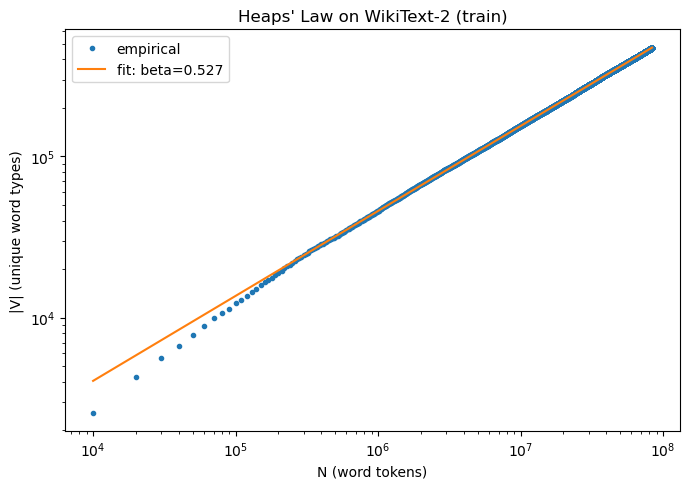

In [9]:
train = ds["train"]
# simple word tokenizer (lowercased)
word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def heaps_curve(dataset, step=10_000):
    V = set()
    N = 0
    Ns, Vs = [], []

    for ex in dataset:
        text = ex["text"]
        if not text or text.strip() == "": # empty word -> continue
            continue
        # make all words to low cases
        words = word_re.findall(text.lower()) 
        for w in words:
            N += 1
            V.add(w)

            if N % step == 0:
                Ns.append(N)
                Vs.append(len(V))
    return np.array(Ns), np.array(Vs)

Ns, Vs = heaps_curve(train, step=10_000)

# Fit log |V| = log k + beta log N  -> linear regression on logs
logN = np.log(Ns)
logV = np.log(Vs)
beta, logk = np.polyfit(logN, logV, 1)
k = np.exp(logk)

print(f"Fitted Heaps' law: |V| ≈ {k:.2f} * N^{beta:.3f}")

# Plot (log-log)
plt.figure(figsize=(7, 5))
plt.loglog(Ns, Vs, marker='o', linestyle='none', markersize=3, label="empirical")

# fitted line
Ns_line = np.linspace(Ns[0], Ns[-1], 200)
Vs_line = k * (Ns_line ** beta)
plt.loglog(Ns_line, Vs_line, label=f"fit: beta={beta:.3f}")

plt.xlabel("N (word tokens)")
plt.ylabel("|V| (unique word types)")
plt.title("Heaps' Law on WikiText-103 (train)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Basics for Python and spaCy

- **Python**: We will use Python-3.12 in our course.
- **spaCy**: As introduced in [https://github.com/explosion/spaCy](https://github.com/explosion/spaCy), [spaCy](https://spacy.io/) is a library for advanced Natural Language Processing in Python and Cython. It's built on the very latest research, and was designed from day one to be used in real products. We will use it to demonostrate how to do text tokenization.
- **nltk tool**: In our previous courses, we will introduce nltk tool for tokenization stuff. But we will not cover this part in our new course as these tools are largely iirelvant and outdated. One can find details of nltk at [https://github.com/nltk/nltk](https://github.com/nltk/nltk) and website at [https://www.nltk.org/](https://www.nltk.org/).

### 3.1 Python basics

In [96]:
# in Python, there is a built in lib re, we can import them
import re


In [97]:
# Task: Find woodchuck or Woodchuck : Disjunction
test_str = "This string contains Woodchuck and woodchuck."
result=re.search(pattern="[wW]oodchuck", string=test_str)
print(result)
result=re.search(pattern=r"[wW]ooodchuck", string=test_str)
print(result)

<re.Match object; span=(21, 30), match='Woodchuck'>
None


In [98]:
# Find the word "woodchuck" in the following test string
test_str = "interesting links to woodchucks ! and lemurs!"
re.search(pattern="woodchuck", string=test_str)

<re.Match object; span=(21, 30), match='woodchuck'>

In [99]:
# Find !, it follows the same way:
print(re.search(pattern="!", string=test_str))
print(re.search(pattern="!!", string=test_str))
assert re.search(pattern="!!", string=test_str) == None # match nothing

<re.Match object; span=(32, 33), match='!'>
None


In [100]:
# Find any single digit in a string.
result=re.search(pattern=r"[0123456789]", string="plenty of 7 to 5")
print(result)
result=re.search(pattern=r"[0-9]", string="plenty of 7 to 5")
print(result)

<re.Match object; span=(10, 11), match='7'>
<re.Match object; span=(10, 11), match='7'>


In [101]:
# Negation: If the caret ^ is the first symbol after [,
# the resulting pattern is negated. For example, the pattern 
# [^a] matches any single character (including special characters) except a.

# -- not an upper case letter
print(re.search(pattern=r"[^A-Z]", string="Oyfn pripetchik"))

# -- neither 'S' nor 's'
print(re.search(pattern=r"[^Ss]", string="I have no exquisite reason for't"))

# -- not a period
print(re.search(pattern=r"[^.]", string="our resident Djinn"))

# -- either 'e' or '^'
print(re.search(pattern=r"[e^]", string="look up ^ now"))

# -- the pattern ‘a^b’
print(re.search(pattern=r'a\^b', string=r'look up a^b now'))

<re.Match object; span=(1, 2), match='y'>
<re.Match object; span=(0, 1), match='I'>
<re.Match object; span=(0, 1), match='o'>
<re.Match object; span=(8, 9), match='^'>
<re.Match object; span=(8, 11), match='a^b'>


In [102]:
# More disjuncations
str1 = "Woodchucks is another name for groundhog!"
result = re.search(pattern="groundhog|woodchuck",string=str1)
print(result)

<re.Match object; span=(31, 40), match='groundhog'>


In [103]:
str1 = "Find all woodchuckk Woodchuck Groundhog groundhogxxx!"
result = re.findall(pattern="[gG]roundhog|[Ww]oodchuck",string=str1)
print(result)

['woodchuck', 'Woodchuck', 'Groundhog', 'groundhog']


In [104]:
# Some special chars

# ?: Optional previous char
str1 = "Find all color colour colouur colouuur colouyr"
result = re.findall(pattern="colou?r",string=str1)
print(result)

# *: 0 or more of previous char
str1 = "Find all color colour colouur colouuur colouyr"
result = re.findall(pattern="colou*r",string=str1)
print(result)

# +: 1 or more of previous char
str1 = "baa baaa baaaa baaaaa"
result = re.findall(pattern="baa+",string=str1)
print(result)
# .: any char
str1 = "begin begun begun beg3n"
result = re.findall(pattern="beg.n",string=str1)
print(result)
str1 = "The end."
result = re.findall(pattern="\.$",string=str1)
print(result)
str1 = "The end? The end. #t"
result = re.findall(pattern=".$",string=str1)
print(result)

['color', 'colour']
['color', 'colour', 'colouur', 'colouuur']
['baa', 'baaa', 'baaaa', 'baaaaa']
['begin', 'begun', 'begun', 'beg3n']
['.']
['t']


<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:22: SyntaxWarning: invalid escape sequence '\.'
/var/folders/5f/z4gt_kmj3qj9rhs1z8yl7nxr0000gn/T/ipykernel_8443/824913852.py:22: SyntaxWarning: invalid escape sequence '\.'
  result = re.findall(pattern="\.$",string=str1)


In [105]:
# find all "the" in a raw text.
text = "If two sequences in an alignment share a common ancestor, \
mismatches can be interpreted as point mutations and gaps as indels (that \
is, insertion or deletion mutations) introduced in one or both lineages in \
the time since they diverged from one another. In sequence alignments of \
proteins, the degree of similarity between amino acids occupying a \
particular position in the sequence can be interpreted as a rough \
measure of how conserved a particular region or sequence motif is \
among lineages. The absence of substitutions, or the presence of \
only very conservative substitutions (that is, the substitution of \
amino acids whose side chains have similar biochemical properties) in \
a particular region of the sequence, suggest [3] that this region has \
structural or functional importance. Although DNA and RNA nucleotide bases \
are more similar to each other than are amino acids, the conservation of \
base pairs can indicate a similar functional or structural role."
matches = re.findall("[^a-zA-Z][tT]he[^a-zA-Z]", text)
print(matches)

[' the ', ' the ', ' the ', ' The ', ' the ', ' the ', ' the ', ' the ']


In [106]:
# A nicer way is to do the following

matches = re.findall(r"\b[tT]he\b", text)
print(matches)

['the', 'the', 'the', 'The', 'the', 'the', 'the', 'the']


In [107]:
def get_wikilink_re():
    """ This regex is from the following Github:
    https://github.com/WikiLinkGraphs/wikidump
    """
    regex_str = r'''(?P<total>(?P<wikilink>
        \[\[(?P<link>[ˆ\n\|\]\[\<\>\{\}]{0,256})(?:\|(?P<anchor>[ˆ\[]*?))?\]\])\w*)\s?'''
    return regex.compile(regex_str, regex.VERBOSE | regex.MULTILINE)

# Task: Implement the task shown in Slides 52
# You may need to
# 1. Download a Wikipedia article xml file
# 2. Use RE to extract links.

### 3.2 spaCy

In [109]:
## install spaCy
!conda install -c conda-forge spacy -y --quiet

/opt/anaconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/opt/anaconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.

Open your terminal and activate your llm-26 env, and then run the following to download English LMs.
```python
python -m spacy download en_core_web_sm
```

In [120]:
import spacy

prompt = "Fudan University is located in which city? Answer with one word."
nlp = spacy.load("en_core_web_sm")
doc = nlp(prompt) # i want to do text preprocessing for our prompt.

# Text: The original word text.
# Lemma: The base form of the word.
# POS: The simple UPOS part-of-speech tag.
# Tag: The detailed part-of-speech tag.
# Dep: Syntactic dependency, i.e. the relation between tokens.
# Shape: The word shape – capitalization, punctuation, digits.
# is alpha: Is the token an alpha character? (whether it consists only of letters from the alphabet (A-Z or a-z))
# is stop: Is the token part of a stop list, i.e. the most common words of the language? 
#         (A stop list (or stopwords list) is a list of commonly used words in a language that 
#         are usually ignored during natural language processing (NLP) tasks, such as text analysis or machine learning.)

for token in doc:
    print(f"--- token: {token.text} ---")
    print(f"lemma: {token.lemma_}\npos: {token.pos_}\ntag: {token.tag_}\ndep: {token.dep_}\nshape: {token.shape_}\nis_alpha:{token.is_alpha}\nis_stop: {token.is_stop}")

--- token: Fudan ---
lemma: Fudan
pos: PROPN
tag: NNP
dep: compound
shape: Xxxxx
is_alpha:True
is_stop: False
--- token: University ---
lemma: University
pos: PROPN
tag: NNP
dep: nsubjpass
shape: Xxxxx
is_alpha:True
is_stop: False
--- token: is ---
lemma: be
pos: AUX
tag: VBZ
dep: auxpass
shape: xx
is_alpha:True
is_stop: True
--- token: located ---
lemma: locate
pos: VERB
tag: VBN
dep: ROOT
shape: xxxx
is_alpha:True
is_stop: False
--- token: in ---
lemma: in
pos: ADP
tag: IN
dep: prep
shape: xx
is_alpha:True
is_stop: True
--- token: which ---
lemma: which
pos: DET
tag: WDT
dep: det
shape: xxxx
is_alpha:True
is_stop: True
--- token: city ---
lemma: city
pos: NOUN
tag: NN
dep: pobj
shape: xxxx
is_alpha:True
is_stop: False
--- token: ? ---
lemma: ?
pos: PUNCT
tag: .
dep: punct
shape: ?
is_alpha:False
is_stop: False
--- token: Answer ---
lemma: answer
pos: VERB
tag: VB
dep: ROOT
shape: Xxxxx
is_alpha:True
is_stop: False
--- token: with ---
lemma: with
pos: ADP
tag: IN
dep: prep
shape: xxxx

There are two type of tokenizations

- **Top-down tokenization**: We define a standard and implement rules to implement that kind of tokenization.
  - word tokenization
  - charater tokenization
- **Bottom-up tokenization**: We use simple statistics of letter sequences to break up words into subword tokens.
  - subword tokenization (modern LLMs use this type!)

In [121]:
# Use split method via the whitespace " "
text = """While the Unix command sequence just removed all the numbers and punctuation"""
print(text.split(" "))

['While', 'the', 'Unix', 'command', 'sequence', 'just', 'removed', 'all', 'the', 'numbers', 'and', 'punctuation']


In [146]:
# But, we have punctuations, icons, and many other small issues.
text = """Don't you love 🤗 Transformers? We sure do."""
print(text.split(" "))

["Don't", 'you', 'love', '🤗', 'Transformers?', 'We', 'sure', 'do.']


In [148]:
# spacy works much better
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
print([token for token in doc])

[Do, n't, you, love, 🤗, Transformers, ?, We, sure, do, .]


In [149]:
text = """Special characters and numbers will need to be kept in prices ($45.55) and dates (01/02/06); 
we don’t want to segment that price into separate tokens of “45” and “55”. And there are URLs (https://www.stanford.edu),
Twitter hashtags (#nlproc), or email addresses (someone@cs.colorado.edu)."""
doc = nlp(text)
print([token for token in doc])

[Special, characters, and, numbers, will, need, to, be, kept, in, prices, (, $, 45.55, ), and, dates, (, 01/02/06, ), ;, 
, we, do, n’t, want, to, segment, that, price, into, separate, tokens, of, “, 45, ”, and, “, 55, ”, ., And, there, are, URLs, (, https://www.stanford.edu, ), ,, 
, Twitter, hashtags, (, #, nlproc, ), ,, or, email, addresses, (, someone@cs.colorado.edu, ), .]


Please install zh tokenization via spaCy: 
```python
python -m spacy download zh_core_web_sm
```

In [151]:
nlp = spacy.load("zh_core_web_sm")
text = '姚明进入总决赛'
doc = nlp(text)
print([token for token in doc])

[姚明, 进入, 总决赛]


In [152]:
text = """1月1日，国务院国资委公布“2025年度央企十大国之重器”，1月2日公布“2025年度央企十大超级工程”。‌‌"""
doc = nlp(text)
print([str(token) for token in doc])

['1月', '1日', '，', '国务院', '国资委', '公布', '“', '2025', '年度', '央企', '十大', '国之重器', '”', '，', '1月', '2日', '公布', '“', '2025', '年度', '央企', '十大', '超级', '工程', '”', '。', '\u200c\u200c']


In [153]:
from spacy.lang.zh import Chinese
nlp_ch = Chinese()
print([*nlp_ch(text)])

[1, 月, 1, 日, ，, 国, 务, 院, 国, 资, 委, 公, 布, “, 2, 0, 2, 5, 年, 度, 央, 企, 十, 大, 国, 之, 重, 器, ”, ，, 1, 月, 2, 日, 公, 布, “, 2, 0, 2, 5, 年, 度, 央, 企, 十, 大, 超, 级, 工, 程, ”, 。, ‌, ‌]


**Lemmatization (词形还原)**

- Lemmatization is the task of determining that two words have the same root, despite their surface differences.
- **Motivation**: For some NLP situations, we also want two morphologically different forms of a word to behave similarly. For example in web search, someone may type the string woodchucks but a useful system might want to also return pages
that mention woodchuck with no s.
- **Example 1**: The words am, are, and is have the shared lemma be.
- **Example 2**: The words dinner and dinners both have the lemma dinner.

In [156]:
text = """
The Brown Corpus, a text corpus of American English that was compiled in the 1960s at Brown University, \
is widely used in the field of linguistics and natural language processing. It contains about 1 million \
words (or "tokens") across a diverse range of texts from 500 sources, categorized into 15 genres, such \
as news, editorial, and fiction, to provide a comprehensive resource for studying the English language. \
This corpus has been instrumental in the development and evaluation of various computational linguistics \
algorithms and tools.
"""
text = text.replace("\n", " ").strip()
print(text)

The Brown Corpus, a text corpus of American English that was compiled in the 1960s at Brown University, is widely used in the field of linguistics and natural language processing. It contains about 1 million words (or "tokens") across a diverse range of texts from 500 sources, categorized into 15 genres, such as news, editorial, and fiction, to provide a comprehensive resource for studying the English language. This corpus has been instrumental in the development and evaluation of various computational linguistics algorithms and tools.


In [157]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
print(doc[0], type(doc[0]))

The <class 'spacy.tokens.token.Token'>


In [158]:
lemmas = [token.lemma_ for token in doc]
for ori,lemma in zip(doc[:30], lemmas[:30]):
    print(ori, lemma)

The the
Brown Brown
Corpus Corpus
, ,
a a
text text
corpus corpus
of of
American American
English English
that that
was be
compiled compile
in in
the the
1960s 1960
at at
Brown Brown
University University
, ,
is be
widely widely
used use
in in
the the
field field
of of
linguistics linguistic
and and
natural natural


**Stemming (词干提取)**

The Porter-Stemmer method

Lemmatization algorithms can be complex. For this reason we sometimes make use of a simpler but cruder method, which mainly consists of chopping off words final affixes. This naive version of morphological analysis is called stemming.

In [159]:
import spacy
nlp = spacy.load("en_core_web_sm")

text = """\
This was not the map we found in Billy Bones's chest, but \
an accurate copy, complete in all things-names and heights \
and soundings-with the single exception of the red crosses \
and the written notes.\
"""   
doc = nlp(text)

for tok in doc:
    if tok.is_alpha:
        print(tok.text, tok.lemma_)

This this
was be
not not
the the
map map
we we
found find
in in
Billy Billy
Bones Bones
chest chest
but but
an an
accurate accurate
copy copy
complete complete
in in
all all
things thing
names name
and and
heights height
and and
soundings sounding
with with
the the
single single
exception exception
of of
the the
red red
crosses cross
and and
the the
written write
notes note


In [160]:
# A modern and fast NLP library that includes support for sentence segmentation. 
# spaCy uses a statistical model to predict sentence boundaries, which can be more accurate 
# than rule-based approaches for complex texts.
# Install via conda: conda install conda-forge::spacy
# Install via pip:   pip install -U spacy
# Download data: python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Here is a sentence. Here is another one! And the last one.")
sentences = [sent.text for sent in doc.sents]
for ind, sent in enumerate(sentences):
    print(f"sentence-{ind}: {sent}\n")

sentence-0: Here is a sentence.

sentence-1: Here is another one!

sentence-2: And the last one.



In [161]:
 # You need to install it via: python -m spacy download zh_core_web_sm
from spacy.lang.zh.examples import sentences 
nlp = spacy.load("zh_core_web_sm")
doc = nlp(sentences[0])
text = """\
字节对编码是一种简单的数据压缩形式，这种方法用数据中不存的一个字节表示最常出现的连续字节数据。这样的替换需要重建全部原始数据。字节对编码实例: 假设我们要编码数据 aaabdaaabac, 字节对“aa”出现次数最多，所以我们用数据中没有出现的字节“Z”替换“aa”得到替换表
Z <- aa 数据转变为 ZabdZabac. 在这个数据中，字节对“Za”出现的次数最多，我们用另外一个字节“Y”来替换它（这种情况下由于所有的“Z”都将被替换，所以也可以用“Z”来替换“Za”），得到替换表以及数据
Z <- aa, Y <- Za, YbdYbac. 我们再次替换最常出现的字节对得到：Z <- aa, Y <- Za, X <- Yb. XdXac 由于不再有重复出现的字节对，所以这个数据不能再被进一步压缩。解压的时候，就是按照相反的顺序执行替换过程。
"""
doc = nlp(text)
sentences = [sent.text for sent in doc.sents]
for ind, sent in enumerate(sentences):
    print(f"sentence-{ind}: {sent}\n")

sentence-0: 字节对编码是一种简单的数据压缩形式，这种方法用数据中不存的一个字节表示最常出现的连续字节数据。

sentence-1: 这样的替换需要重建全部原始数据。

sentence-2: 字节对编码实例: 假设我们要编码数据 aaabdaaabac, 字节对“aa”出现次数最多，所以我们用数据中没有出现的字节“Z”替换“aa”得到替换表
Z <- aa 数据转变为 ZabdZabac.

sentence-3: 在这个数据中，字节对“Za”出现的次数最多，我们用另外一个字节“Y”来替换它（这种情况下由于所有的“Z”都将被替换，所以也可以用“Z”来替换“Za”），得到替换表以及数据
Z <- aa, Y <- Za, YbdYbac.

sentence-4: 我们再次替换最常出现的字节对得到：Z <- aa, Y <- Za, X <-

sentence-5: Yb.

sentence-6: XdXac 由于不再有重复出现的字节对，所以这个数据不能再被进一步压缩。

sentence-7: 解压的时候，就是按照相反的顺序执行替换过程。




## 4. LLMs tokenization

In [171]:
!conda install conda-forge::tiktoken -y --quiet

/opt/anaconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/opt/anaconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.

### 4.1 Subword tokenization: BPE

### 4.4 Huggingface tokenizer

PreTrainedTokenizer, PreTrainedTokenizerBase, AutoTokenizer

- https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_base.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_fast.py
- Check tokenizers at https://github.com/huggingface/transformers/blob/main/setup.py
- If you want to train a tokenizer by yourself, then go to: https://github.com/huggingface/tokenizers
- A fast BPE tokenizer is also at: https://github.com/openai/tiktoken
- An implementation of sentencepiece is at: https://github.com/google/sentencepiece
- There are 3 most common methods for tokenization: https://github.com/huggingface/tokenizers/tree/main/tokenizers/src/models
- - BPE: https://aclanthology.org/P16-1162.pdf
  - Unigram: https://arxiv.org/pdf/1804.10959
  - WordPiece https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf

In [ ]:
from transformers import Qwen2Tokenizer, Qwen2TokenizerFast

## 5. Minimum Edit Distance

In [168]:
import numpy as np

# define minimum edit distance algorithm via dynamic programming
def minimum_edit_distance(source, target):
    n = len(source)
    m = len(target)
    d_mat = np.zeros((n + 1, m + 1))
    for i in range(1, n + 1):
        d_mat[i, 0] = i
    for j in range(1, m + 1):
        d_mat[0, j] = j
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            sub = 0 if source[i - 1] == target[j - 1] else 2
            del_ = d_mat[i - 1][j] + 1
            ins_ = d_mat[i][j - 1] + 1
            d_mat[i][j] = min(del_, ins_, d_mat[i - 1][j - 1] + sub)
    trace, align_source, align_target = backtrack_alignment(source, target, d_mat)
    return d_mat[n, m], trace, align_source, align_target

def backtrack_alignment(source, target, d_mat):
    align_source, align_target = [], []
    i, j = len(source), len(target)
    back_trace = [[i, j]]

    while (i, j) != (0, 0):
        # boundary cases first (avoid negative indexing)
        if i == 0:
            back_trace.append([i, j - 1])
            align_source = ["*"] + align_source
            align_target = [target[j - 1]] + align_target
            j -= 1
            continue
        if j == 0:
            back_trace.append([i - 1, j])
            align_source = [source[i - 1]] + align_source
            align_target = ["*"] + align_target
            i -= 1
            continue

        sub_cost = 0 if source[i - 1] == target[j - 1] else 2

        # prefer substitution/match when optimal (your tie-break rule)
        if d_mat[i, j] == d_mat[i - 1, j - 1] + sub_cost:
            back_trace.append([i - 1, j - 1])
            align_source = [source[i - 1]] + align_source
            align_target = [target[j - 1]] + align_target
            i, j = i - 1, j - 1

        # deletion
        elif d_mat[i, j] == d_mat[i - 1, j] + 1:
            back_trace.append([i - 1, j])
            align_source = [source[i - 1]] + align_source
            align_target = ["*"] + align_target
            i -= 1

        # insertion
        else:
            back_trace.append([i, j - 1])
            align_source = ["*"] + align_source
            align_target = [target[j - 1]] + align_target
            j -= 1

    return back_trace, align_source, align_target

# test the minimum edit distance
def test_med(source, target):
    med, trace, align_source, align_target = minimum_edit_distance(source, target)
    print(f"input source: {source} and target: {target}")
    print(f"med: {med}")
    print(f"trace: {trace}")
    print(f"aligned source: {align_source}")
    print(f"aligned target: {align_target}")

In [169]:
test_med(source="INTENTION", target="EXECUTION")

input source: INTENTION and target: EXECUTION
med: 8.0
trace: [[9, 9], [8, 8], [7, 7], [6, 6], [5, 5], [4, 4], [4, 3], [3, 2], [2, 1], [1, 0], [0, 0]]
aligned source: ['I', 'N', 'T', 'E', '*', 'N', 'T', 'I', 'O', 'N']
aligned target: ['*', 'E', 'X', 'E', 'C', 'U', 'T', 'I', 'O', 'N']


In [170]:
test_med(source="AGGCTATCACCTGACCTCCAGGCCGATGCCC", target="TAGCTATCACGACCGCGGTCGATTTGCCCGAC")

input source: AGGCTATCACCTGACCTCCAGGCCGATGCCC and target: TAGCTATCACGACCGCGGTCGATTTGCCCGAC
med: 15.0
trace: [[31, 32], [30, 31], [30, 30], [30, 29], [29, 28], [28, 27], [28, 26], [27, 25], [26, 24], [26, 23], [26, 22], [25, 21], [24, 20], [23, 19], [22, 18], [21, 17], [20, 16], [19, 16], [18, 15], [17, 14], [16, 14], [15, 13], [14, 12], [13, 11], [12, 10], [11, 10], [10, 9], [9, 9], [8, 8], [7, 7], [6, 6], [5, 5], [4, 4], [3, 3], [2, 2], [1, 2], [0, 1], [0, 0]]
aligned source: ['*', 'A', 'G', 'G', 'C', 'T', 'A', 'T', 'C', 'A', 'C', 'C', 'T', 'G', 'A', 'C', 'C', 'T', 'C', 'C', 'A', 'G', 'G', 'C', 'C', 'G', 'A', '*', '*', 'T', 'G', '*', 'C', 'C', '*', '*', 'C']
aligned target: ['T', 'A', '*', 'G', 'C', 'T', 'A', 'T', 'C', 'A', '*', 'C', '*', 'G', 'A', 'C', 'C', '*', 'G', 'C', '*', 'G', 'G', 'T', 'C', 'G', 'A', 'T', 'T', 'T', 'G', 'C', 'C', 'C', 'G', 'A', 'C']
